# SVM и его ядра
__Суммарное количество баллов: 9__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW07] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании нам предстоит решить задачу SVM при помощи `cvxopt` и применить ее к искуственным данным. Затем аналогичным способом нужно будет решить задачу ядерного SVM и исследовать его поведение для различных ядер и значений их параметров.

In [2]:
import numpy as np
import copy
from cvxopt import spmatrix, matrix, solvers
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons, make_blobs

solvers.options['show_progress'] = False

In [3]:
def visualize(clf, X, y):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_border = (x_max - x_min) / 20 + 1.0e-3
    x_h = (x_max - x_min + 2 * x_border) / 200
    y_border = (y_max - y_min) / 20 + 1.0e-3
    y_h = (y_max - y_min + 2 * y_border) / 200
    
    cm = plt.cm.Spectral

    xx, yy = np.meshgrid(np.arange(x_min - x_border, x_max + x_border, x_h), np.arange(y_min - y_border, y_max + y_border, y_h))
    mesh = np.c_[xx.ravel(), yy.ravel()]

    z_class = clf.predict(mesh).reshape(xx.shape)

    # Put the result into a color plot
    plt.figure(1, figsize=(8, 8))
    plt.pcolormesh(xx, yy, z_class, cmap=cm, alpha=0.3, shading='gouraud')

    # Plot hyperplane and margin
    z_dist = clf.decision_function(mesh).reshape(xx.shape)
    plt.contour(xx, yy, z_dist, [0.0], colors='black')
    plt.contour(xx, yy, z_dist, [-1.0, 1.0], colors='black', linestyles='dashed')

    # Plot also the training points
    y_pred = clf.predict(X)

    ind_support = []
    ind_correct = []
    ind_incorrect = []
    for i in range(len(y)):
        if i in clf.support:
            ind_support.append(i)
        elif y[i] == y_pred[i]:
            ind_correct.append(i)
        else:
            ind_incorrect.append(i)

    plt.scatter(X[ind_correct, 0], X[ind_correct, 1], c=y[ind_correct], cmap=cm, alpha=1., edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_incorrect, 0], X[ind_incorrect, 1], c=y[ind_incorrect], cmap=cm, alpha=1., marker='*',
               s=50, edgecolor='black', linewidth=.8)
    plt.scatter(X[ind_support, 0], X[ind_support, 1], c=y[ind_support], cmap=cm, alpha=1., edgecolor='yellow', linewidths=1.,
               s=40)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()

In [4]:
def generate_dataset(moons=False):
    if moons:
        X, y = make_moons(1000, noise=0.075, random_state=42)
        return X, 2 * y - 1
    X, y = make_blobs(1000, 2, centers=[[0, 0], [-4, 2], [3.5, -2.0], [3.5, 3.5]], random_state=42)
    y = 2 * (y % 2) - 1
    return X, y
    #return make_classification(1000, 2, 2, 0, flip_y=0.001, class_sep=1.2, scale=0.9, random_state=42)

X, y = generate_dataset(True)

### Задание 1 (2 балла)
Для начала реализуем обычный линейный SVM. 

#### Методы
`fit(X, y)` - обучает SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Поля
`support` - индексы опорных элементов

In [72]:
class LinearSVM:
    def __init__(self, C):
        self.C = C
        self.support = []
        self.w = None
        self.b = None

    def fit(self, X, y):
        EPS = np.float64(1e-8)
        N = len(X)
        Y = y.reshape(-1, 1)
        P = matrix((X.dot(X.T)) * (Y.dot(Y.T)))
        q = matrix(np.ones_like(Y, dtype=np.float64) * -1)
        eN = np.eye(N)
        G = matrix(np.vstack((eN * -1, eN)))
        h = matrix(np.vstack((np.zeros_like(Y, dtype=np.float64), np.ones_like(Y) * self.C)))
        A = matrix(Y.T.astype(dtype=np.float64))
        B = matrix(np.zeros((1, 1)))
        alpha = np.array(solvers.qp(P, q, G, h, A, B)['x'])
        self.w = X.T.dot(alpha * Y)
        self.support = np.argwhere(alpha > EPS).reshape(-1).tolist()
        good_support = np.argwhere(np.where(alpha < self.C - EPS, alpha, -1) > EPS).reshape(-1)[0]
        self.b = self.w.T.dot(X[good_support]) - 1 / y[good_support]
        
    def decision_function(self, X):
        return X.dot(self.w) - self.b

    def predict(self, X):
        return np.sign(self.decision_function(X))

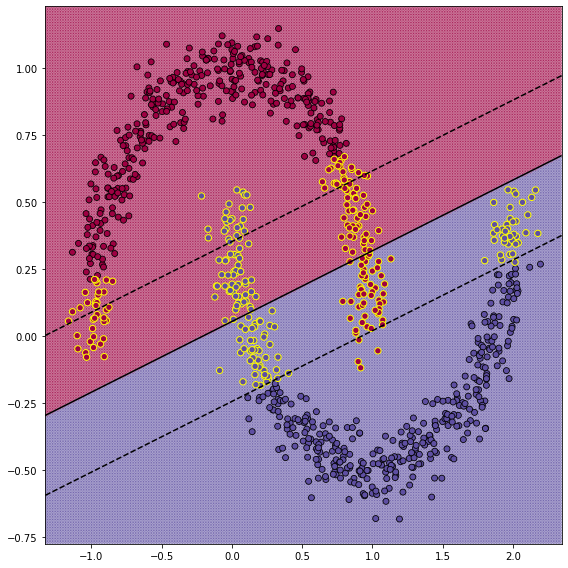

In [83]:
X, y = generate_dataset(True)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()
fn = time.time()

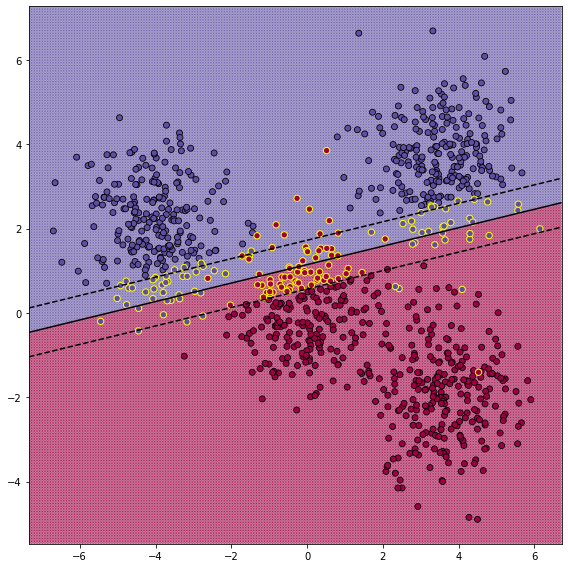

In [84]:
X, y = generate_dataset(False)
svm = LinearSVM(1)
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

### Задание 2 (2 балла)
Перед реализацией ядерного SVM, реализуем функции, которые строят ядра.

#### Описание
`get_polynomial_kernel(power)` - возвращает полиномиальное ядро с заданной константой и степенью

`get_gaussian_kernel(sigma=1.)` - возвращает ядро Гаусса с заданным коэффицинтом сигма

In [ ]:
def get_polynomial_kernel(c=1, power=2):
    return lambda x, y: (c + np.sum(x.T.dot(y))) ** power

def get_gaussian_kernel(sigma=1.):
    return lambda x, y: 

### Задание 3 (2 балла)
Теперь перейдем к реализации самого kernel SVM.

#### Описание
`fit(X, y)` - обучает kernel SVM, решая задачу оптимизации при помощи `cvxopt.solvers.qp`

`decision_function(X)` - возвращает значение решающей функции (т.е. то число, от которого берем знак с целью узнать класс)

#### Конструктор
`kernel` - ядро-функция

In [ ]:
class KernelSVM:
    def __init__(self, C, kernel=linear_kernel):
        self.C = C
        self.kernel = kernel
        self.support = None

    def fit(self, X, y):
        pass

    def decision_function(self, X):
        pass

    def predict(self, X):
        return np.sign(self.decision_function(X))

In [ ]:
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_polynomial_kernel(1, 3))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(True)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

In [ ]:
X, y = generate_dataset(False)
svm = KernelSVM(1, kernel=get_gaussian_kernel(0.4))
svm.fit(X, y)
visualize(svm, X, y)
plt.show()

### Задание 4 (3 балла)
Исследуйте и опишите влияние параметров каждого вида ядра на полученный классификатор. Что происходит при увеличении константы в полиномиальном ядре? При увеличении степени? Как влияет на результат сигма в ядре Гаусса?

__При выполнении этого задания стоит написать код, который визуализирует классификаторы с различными ядрами__